In [1]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import numpy as np

import mlgrad.regr as regr

# import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.func as func
#import mlgrad.regular as regular
import mlgrad.loss as loss
# import mlgrad.weights as weights
# import mlgrad.averager as averager

import sklearn.linear_model as linear_model

# from mlgrad import averager_it, averager_fg, fg, erm_fg, irgd, erm_irgd, erisk, aerisk

In [2]:
def gendataset(N=70, a=6., b=6., q=0.4, dy=2.):
    M = int(q*N)
    X0 = np.linspace(-12., 12., N+1)
    Y0 = 2.+3.*X0
    Y0 += 2*dy*np.random.random(N+1)-dy
    if q > 0:
        X1 = a*np.random.random(M) - a - 18
        Y1 = b*(2*np.random.random(M)-1)
        Y1 += 2.+3.*X1 + 70
        X2 = a*np.random.random(M) - a + 24
        Y2 = b*(2*np.random.random(M)-1)
        Y2 += 2.+3.*X2 - 60
        X = np.hstack((X0, X1, X2))
        Y = np.hstack((Y0, Y1, Y2))
    else:
        X = X0
        Y = Y0
    Xs = X.reshape(-1,1)
    xrange = np.linspace(-12., 12., 10).reshape(-1,1)
    return X, Y, Xs, M, xrange

In [3]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_hub = loss.ErrorLoss(func.Huber())
# loss_func_sqrt = loss.ErrorLoss(func.Sqrt())
loss_func_logsq = loss.ErrorLoss(func.LogSquare(1.))
# loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_tukey = loss.ErrorLoss(func.Tukey(33.))

In [4]:
N = 30
q = 0.4
dy = 4
X1, Y1, X1s, M, xrange0  = gendataset(N, q=q, dy=dy)
X0, Y0, X0s, M0, xrange0  = gendataset(N, q=0, dy=dy)
Q = 2*M / (N+2.*M) * 100
print(Q, X1.shape)

44.44444444444444 (55,)


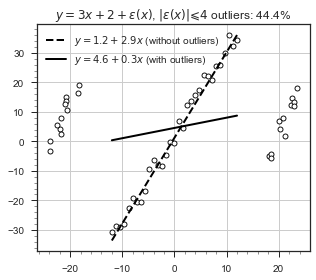

In [5]:
lm_ls0 = model.LinearModel(1)
lm_ls0.init_param()
alg_ls0 = regr.regression(X0s, Y0, lm_ls0, h=0.01, n_restart=1)

lm_ls = model.LinearModel(1)
lm_ls.init_param()
alg_ls = regr.regression(X1s, Y1, lm_ls, h=0.01, n_restart=1)

plt.figure(figsize=(4.5, 4.))
plt.title(r'$y=3x+2+\varepsilon(x)$, $|\varepsilon(x)|\leqslant%s$ outliers: %.1f%%' % (dy,Q,))
plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(X0, alg_ls0.risk.model.evaluate_all(X0s), color='k', linewidth=2., 
         label=r'$y=%.1f+%.1fx$ (without outliers)' % tuple(lm_ls0.param), linestyle='--')
plt.plot(X0, alg_ls.risk.model.evaluate_all(X0s), color='k', linewidth=2., 
         label=r'$y=%.1f+%.1fx$ (with outliers)' % tuple(lm_ls.param), linestyle='-')
plt.grid(1)
# plt.xlabel('x')
# plt.ylabel('y')
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('fig/rob_ml_linear_ls_%.0f_eng.eps' % Q)
plt.show()

In [6]:
param_hub = np.array([1.,-1.])
param_sqrt = np.array([1.,-1.])
param_logsq = np.array([1.,-1.])
param_tukey = np.array([1.,-1.])

lm_hub = model.LinearModel(1)
lm_logsq = model.LinearModel(1)
lm_tukey = model.LinearModel(1)
lm_hub.init_param()
lm_logsq.init_param()
lm_tukey.init_param()

alg_hub = regr.regression(X1s, Y1, lm_hub, loss_func_hub, h=0.1, n_restart=2)
alg_logsq = regr.regression(X1s, Y1, lm_logsq, loss_func_logsq, h=0.1, n_restart=2)
alg_tukey = regr.regression(X1s, Y1, lm_tukey, loss_func_logsq, h=0.1, n_restart=2)

def plot_classic():
    plt.title("%.0f%% outliers" % Q)
    plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
    plt.plot(X0, alg_hub.risk.model.evaluate_all(X0s), color='k', linewidth=2., label=r'Huber: $y=%.1f%+.1fx$' % tuple(lm_hub.param), linestyle='-.')
#     plt.plot(X0, alg_logsq.risk.model.evaluate_all(X0s), color='k', linewidth=2., label=r'logsq: $y=%.1f%.1fx$' % tuple(lm_logsq.param), linestyle='-')
    plt.plot(X0, alg_tukey.risk.model.evaluate_all(X0s), color='k', linewidth=2., label=r'Tukey: $y=%.1f%+.1fx$' % tuple(lm_tukey.param), linestyle='--')
#     plt.plot(X0, alg_ls.risk.model.evaluate_all(X0s), color='k', linewidth=2., label='ls: y=%.1f+%.1fx' % tuple(lm_ls.param), linestyle=':')
    plt.grid(1)
    plt.minorticks_on()
    plt.legend()

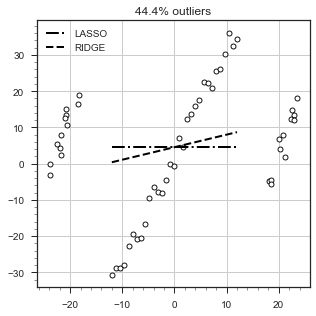

In [7]:
alg_ridge = linear_model.Ridge(alpha=100.)
alg_ridge.fit(X1s, Y1)
alg_lasso = linear_model.Lasso(alpha=100.)
alg_lasso.fit(X1s, Y1)

plt.figure(figsize=(4.5, 4.5))
# def lasso_ridge():
plt.title("%.1f%% outliers" % Q)
plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(xrange0, alg_lasso.predict(xrange0), color='k', linewidth=2., label=r'LASSO', linestyle='-.')
plt.plot(xrange0, alg_ridge.predict(xrange0), color='k', linewidth=2., label=r'RIDGE', linestyle='--')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/rob_ml_linear_lasso_%.0f_eng.png" % Q)
plt.show()

0.5555555555555556


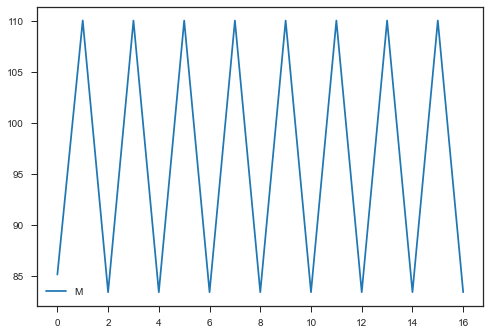

In [9]:
param_m = np.array([1.,-1])

lm_m = model.LinearModel(param_m)

alpha = 1.0 - Q/100
print(alpha)
rhofunc=func.Quantile_Sqrt(alpha, 0.001)

avg_m = regr.averaging_function('M', rhofunc=rhofunc)
alg_m = regr.m_regression_irls(X1s, Y1, lm_m, agg_func=avg_m, h=0.01)

plt.plot(alg_m.lvals, label='M')
plt.legend()
plt.show()

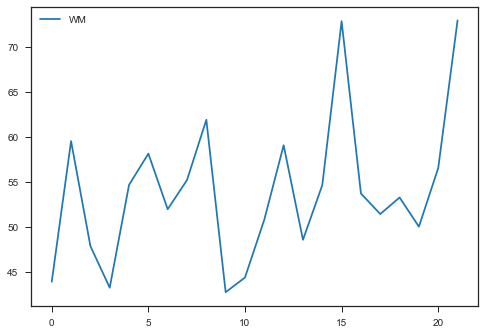

In [10]:
param_wm = np.array([1.,-1])

lm_wm = model.LinearModel(param_wm)

avg_wm = regr.averaging_function('WM', rhofunc=rhofunc)
alg_wm = regr.m_regression_irls(X1s, Y1, lm_wm, agg_func=avg_wm, h=0.01)

plt.plot(alg_wm.lvals, label='WM')
plt.legend()
plt.show()

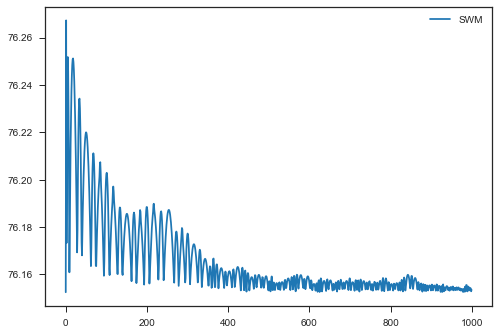

In [18]:
# param_swm = np.array([1.,-1])
# lm_swm = model.LinearModel(param_swm)

avg_swm = regr.averaging_function('SWM', rhofunc=rhofunc)
alg_swm = regr.m_regression(X1s, Y1, lm_swm, agg_func=avg_swm, h=0.001)

plt.plot(alg_swm.lvals, label='SWM')
plt.legend()
plt.show()

In [19]:
def plot_robust():
    plt.title(r"%.0f%% outliers, $\alpha=%.2f$" % (Q, alpha))
    plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
    plt.plot(xrange0, lm_m.evaluate_all(xrange0), color='k', linewidth=2., 
             label=r'M$_\alpha,\ y=%.1f%+.1fx$' % tuple(lm_m.param), linestyle='-')
    plt.plot(xrange0, lm_wm.evaluate_all(xrange0), color='k', linewidth=2., 
             label=r'WM$_\alpha,\ y=%.1f%+.1fx$' % tuple(lm_wm.param), linestyle='--')
#     plt.plot(xrange0, lm_swm.evaluate_all(xrange0), color='k', linewidth=2., 
#              label=r'SWM$_\alpha,\ y=%.1f+%.1fx$' % tuple(lm_swm.param), linestyle='-.')
    # plt.plot(xrange0, lm_line22_logsq.evaluate_all(xrange0), color='k', linewidth=2., label='logsquare', linestyle='-.')
    # plt.plot(xrange0, lm_line22_tukey.evaluate_all(xrange0), color='k', linewidth=2., label='tukey', linestyle='--')
    plt.grid(1)
    plt.minorticks_on()
    plt.legend()

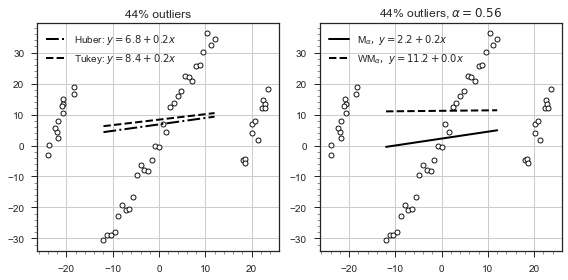

In [20]:
plt.figure(figsize=(8.0,4.0))
plt.subplot(1,2,1)
plot_classic()
plt.subplot(1,2,2)
plot_robust()
plt.tight_layout()
plt.savefig("fig/rb_ml_linear_%.0f_eng.eps" % Q)
plt.show()